# Importing Libraries

__NOTE:__
1. Learning Rate Scheduler is used in this notebook (it changes the learning rate based on some condition)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import kornia as K
import seaborn as sns
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters

In [2]:
n_channels = 1
epochs = 100
batch_size = 32
learning_rate = 0.001
p = 0.0
aug_p = 0.5

# Loading Data

In [3]:
base_folder = './data'
fashion_mnist_train = datasets.FashionMNIST(base_folder, download = True, train = True)
train_images, train_labels = fashion_mnist_train.data, fashion_mnist_train.targets
fashion_mnist_valid = datasets.FashionMNIST(base_folder, download = True, train = False)
valid_images, valid_labels = fashion_mnist_valid.data, fashion_mnist_valid.targets

In [4]:
# Augmentation
class Augmentation(nn.Module):
    def __init__(self, aug_p = 0.5, train = True):
        super(Augmentation, self).__init__()
        self.train = train
        if train:
            deg_rot = 30
            translate = (0.1, 0.1)
            scale = (0.8,1.1)
            # same_on_batch = True to apply same transformation on batch
            self.affine_aug = K.augmentation.RandomAffine(deg_rot, translate, scale = scale, p = aug_p)
            self.horizontal_flip = K.augmentation.RandomHorizontalFlip(p = aug_p)
            self.resize = K.augmentation.Resize([28,28])
        else:
            self.resize = K.augmentation.Resize([28,28])
    
    def forward(self, img):
        if self.train:
            img_aug = self.affine_aug(self.horizontal_flip(self.resize(img)))
        else:
            img_aug = self.resize(img)
        return img_aug

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, imgs, lbls, augment = None):
        # Flattening image
        self.imgs = imgs
        self.lbls = lbls
        self.augment = augment
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img, lbl = self.imgs[idx], self.lbls[idx]
        
        # Normalize input image to be in between 0-1
        img = img / 255.
        
        # Add Channel Dimension (fake dimension)
        img = img[None, :, :]
        return img, lbl
    
    def collate_fn(self, batch):
        imgs, lbls = list(zip(*batch))
        imgs = torch.stack(imgs)
        lbls = torch.tensor(lbls)
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        if self.augment:
            imgs = self.augment(imgs)
        return imgs, lbls

In [6]:
def get_data(aug_p = 0.5, bs = 64):
    train_augmentation = Augmentation(aug_p, train = True)
    train_data = FMNISTDataset(train_images, train_labels, augment = train_augmentation)
    trainloader = DataLoader(train_data, batch_size = bs, shuffle = True, collate_fn = train_data.collate_fn)
    valid_augmentation = Augmentation(aug_p, train = False)
    valid_data = FMNISTDataset(valid_images, valid_labels, augment = valid_augmentation)
    validloader = DataLoader(valid_data, batch_size = bs, collate_fn = train_data.collate_fn)
    return trainloader, validloader

In [7]:
def build_model(p = 0.5, n_channels = 1, lr = 1e-03):
    # Architecture inspired from LeNet (Source: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf)
    # Slight modification compared to original LeNet Paper
    
    model = nn.Sequential(nn.Conv2d(n_channels, out_channels = 6, kernel_size = 5, stride = 1),
                          nn.MaxPool2d(kernel_size = 2, stride = 2),
                          nn.ReLU(),
                          nn.Conv2d(6, out_channels = 16, kernel_size = 5, stride = 1),
                          nn.MaxPool2d(kernel_size = 2, stride = 2),
                          nn.ReLU(),
                          nn.Flatten(),
                          nn.Dropout(p),
                          nn.Linear(256, 120),
                          nn.ReLU(),
                          nn.Dropout(p),
                          nn.Linear(120, 84),
                          nn.ReLU(),
                          nn.Linear(84, 10))
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.2, patience = 20, 
                                                     threshold = 0.1, verbose = True, min_lr = 1e-05)
    return model, criterion, optimizer, scheduler

def train_batch(imgs, lbls, model, criterion, optimizer, valid = False):
    optimizer.zero_grad()
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    out = model(imgs)
    batch_loss = criterion(out, lbls)
    if not valid:
        batch_loss.backward()
        optimizer.step()
    return batch_loss.item()

def no_of_correct(imgs, lbls, model):
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    with torch.no_grad():
        model.eval()
        out = model(imgs)
        _, preds= out.max(-1)
        correct_preds = preds == lbls
        return correct_preds.cpu().numpy().sum(), len(lbls)

In [8]:
def train(p, epochs, learning_rate, aug_p = 0.5):
    trainloader, validloader = get_data(aug_p, batch_size)
    model, criterion, optimizer, scheduler = build_model(p, lr = learning_rate)
    train_accuracies, valid_accuracies = [], []
    train_losses, valid_losses = [], []
    for epoch in range(epochs+1):
        batch_loss = 0.0
        model.train()
        for imgs, lbls in trainloader:
            batch_loss += train_batch(imgs, lbls, model, criterion, optimizer)

        total_correct = 0
        total = 0
        for imgs, lbls in trainloader:
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total

        epoch_train_acc = total_correct/total
        train_accuracies.append(epoch_train_acc)
        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        total_correct = 0
        total = 0
        for imgs, lbls in validloader:
            batch_loss += train_batch(imgs, lbls, model, criterion, optimizer, valid = True)
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total
            

        epoch_valid_loss = batch_loss / len(validloader)
        epoch_valid_acc = total_correct / total
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)
        
        scheduler.step(epoch_valid_loss)

        if epoch % 10 == 0:
            print(f"{'*'*10} EPOCH {epoch:2}/{epochs} {'*'*10}")
            print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}, Train Accuracy: {epoch_train_acc*100:5.2f}
Valid Loss: {epoch_valid_loss:5.3f}, Valid Accuracy: {epoch_valid_acc*100:5.2f}
{"#"*33}''')
        
    return model, train_losses, train_accuracies, valid_losses, valid_accuracies

In [9]:
model, _, _, _ = build_model()
summary(model, torch.rand(32, 1, 28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 24, 24]           156
├─MaxPool2d: 1-2                         [-1, 6, 12, 12]           --
├─ReLU: 1-3                              [-1, 6, 12, 12]           --
├─Conv2d: 1-4                            [-1, 16, 8, 8]            2,416
├─MaxPool2d: 1-5                         [-1, 16, 4, 4]            --
├─ReLU: 1-6                              [-1, 16, 4, 4]            --
├─Flatten: 1-7                           [-1, 256]                 --
├─Dropout: 1-8                           [-1, 256]                 --
├─Linear: 1-9                            [-1, 120]                 30,840
├─ReLU: 1-10                             [-1, 120]                 --
├─Dropout: 1-11                          [-1, 120]                 --
├─Linear: 1-12                           [-1, 84]                  10,164
├─ReLU: 1-13                             [-1, 84]                  --
├─L

In [10]:
model, train_losses, train_accuracies, valid_losses, valid_accuracies = train(p, epochs, learning_rate, aug_p)

********** EPOCH  0/100 **********
#################################
Train Loss: 0.846, Train Accuracy: 74.26
Valid Loss: 0.683, Valid Accuracy: 73.93
#################################
********** EPOCH 10/100 **********
#################################
Train Loss: 0.411, Train Accuracy: 84.98
Valid Loss: 0.434, Valid Accuracy: 83.92
#################################
********** EPOCH 20/100 **********
#################################
Train Loss: 0.368, Train Accuracy: 86.55
Valid Loss: 0.401, Valid Accuracy: 85.02
#################################
********** EPOCH 30/100 **********
#################################
Train Loss: 0.350, Train Accuracy: 87.66
Valid Loss: 0.387, Valid Accuracy: 86.02
#################################
Epoch 00035: reducing learning rate of group 0 to 2.0000e-04.
********** EPOCH 40/100 **********
#################################
Train Loss: 0.298, Train Accuracy: 88.91
Valid Loss: 0.344, Valid Accuracy: 87.32
#################################
********** EP

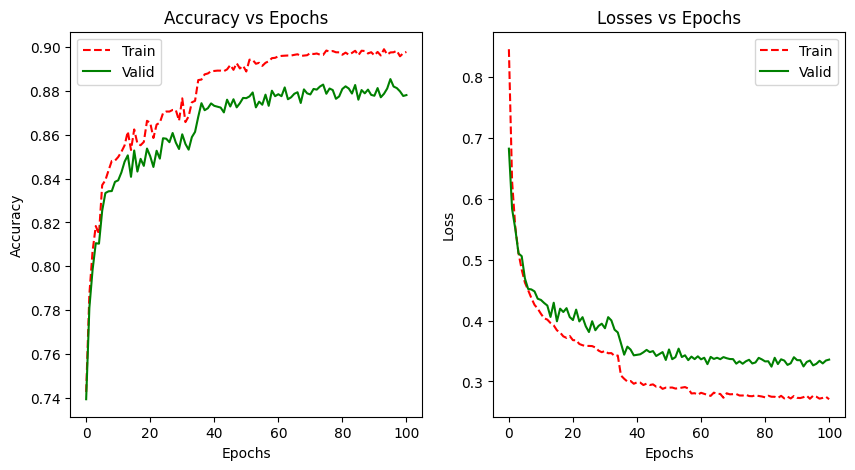

In [11]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

# CNN impact on translation

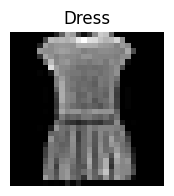

In [12]:
idx = 3
img, lbl = train_images[idx], train_labels[idx]
plt.figure(figsize = (2,2))
plt.imshow(img, cmap = 'gray')
plt.title(fashion_mnist_train.classes[lbl])
plt.axis('off');

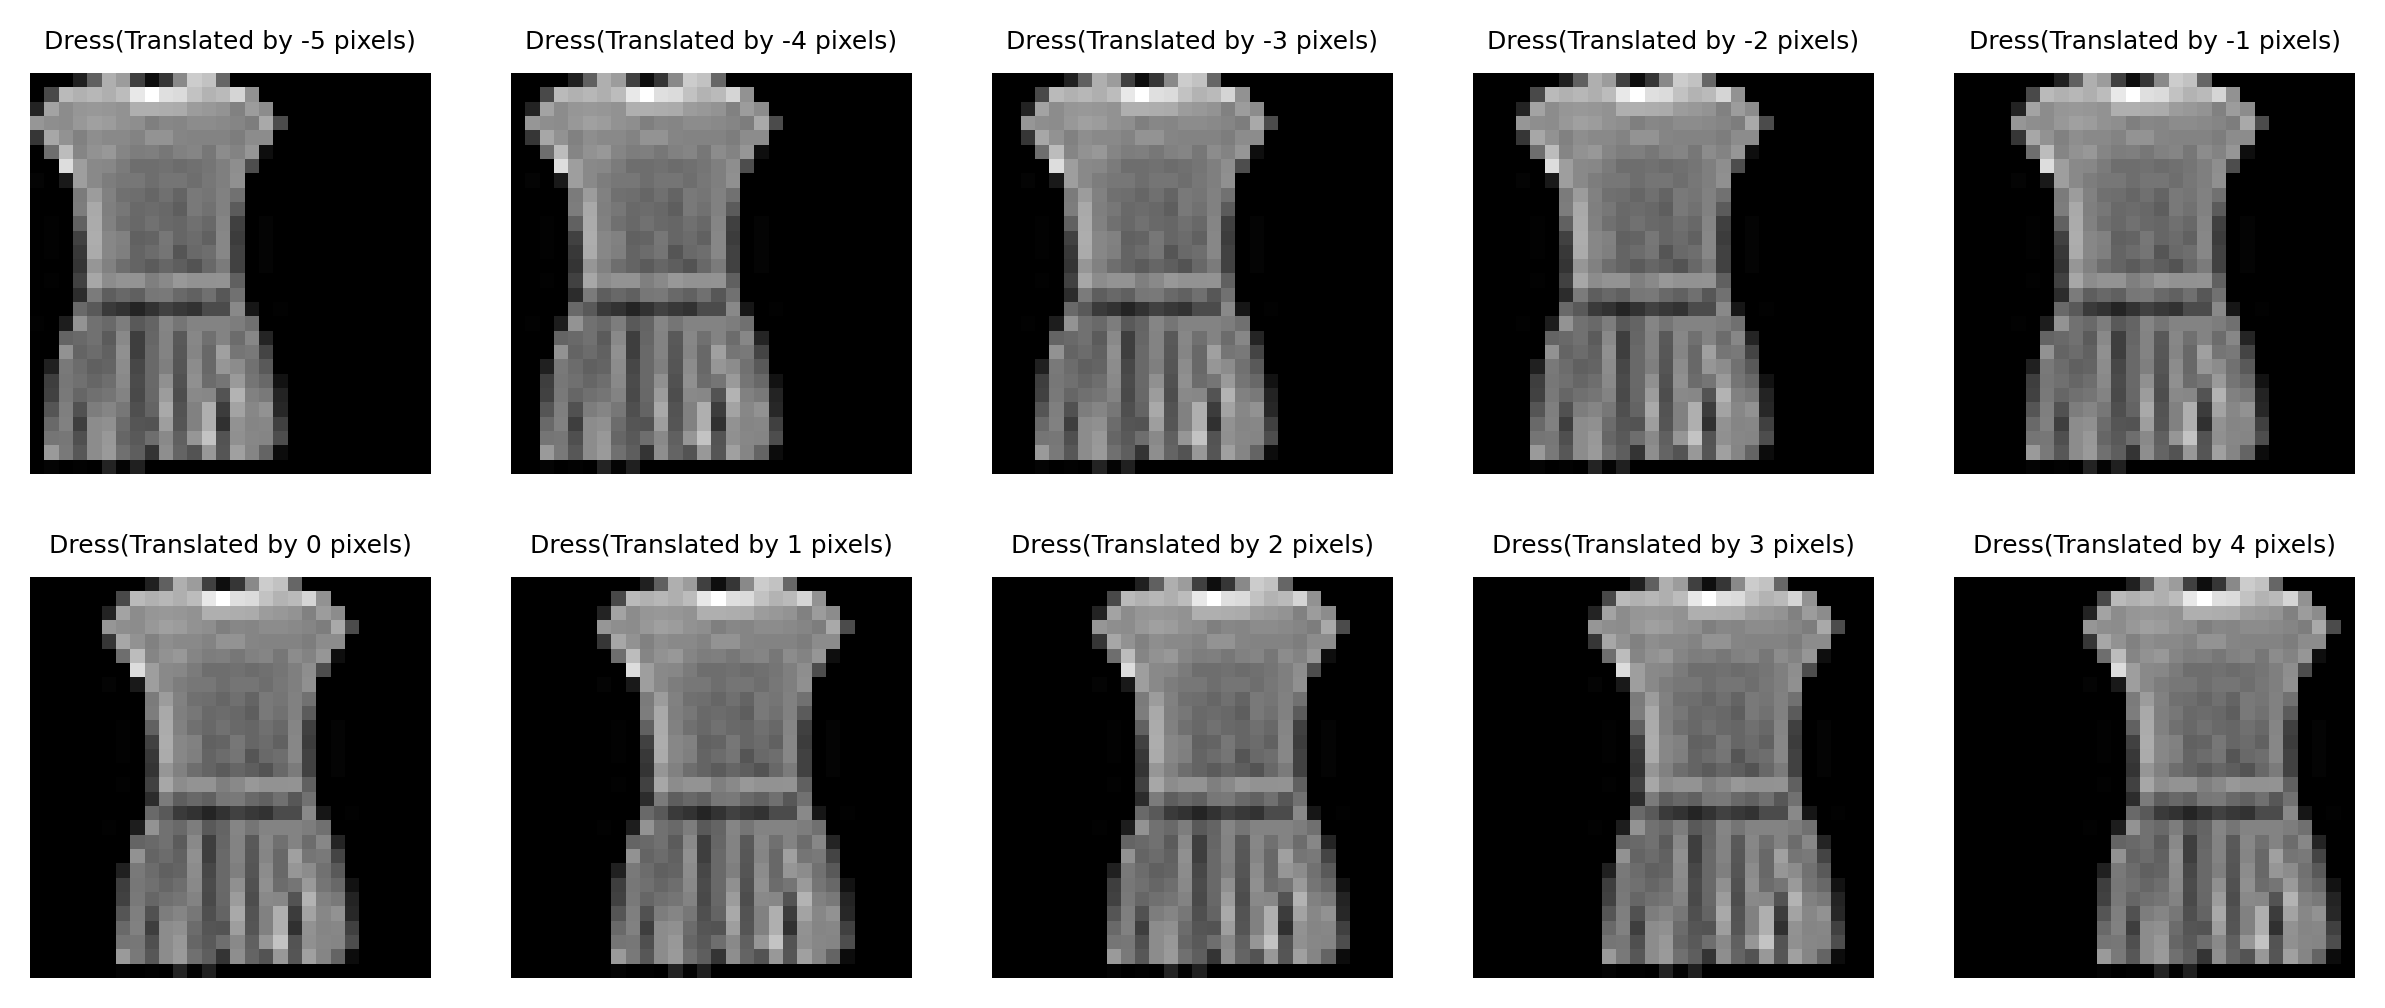

In [15]:
n = 5
h,w = img.shape
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (10,4), dpi = 300)
idx = 0
all_preds = []
for i in range(-n, n):
    translated_tensor = torch.zeros_like(img)
    if i < 0:
        translated_tensor[:,:w+i] = img[:,-i:]
    if i == 0:
        translated_tensor[:,:] = img[:, :]
    if i>0:
        translated_tensor[:,i:] = img[:,:-i]
        
    final_img = translated_tensor.to(device) / 255.
    final_img = final_img[None, None, :, :]
    preds = model(final_img)
    softmax_output = torch.exp(preds) / torch.sum(torch.exp(preds))
    all_preds.append(softmax_output.view(-1).cpu().detach().numpy())
    label_predicted = fashion_mnist_train.classes[torch.max(preds, -1)[-1].item()]
    axes[idx//5, idx%5].imshow(translated_tensor, cmap = 'gray')
    axes[idx//5, idx%5].axis('off')
    axes[idx//5, idx%5].set_title(label_predicted+f'(Translated by {i} pixels)', fontsize = 6)
    idx+=1

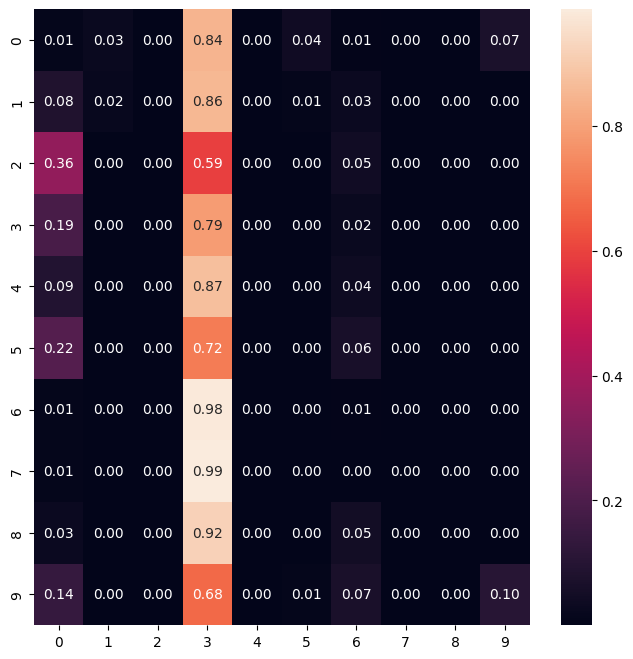

In [16]:
preds_data = np.array(all_preds)
plt.figure(figsize = (8,8))
sns.heatmap(preds_data, annot = True, fmt = '.2f');

- Here as it is evident almost all predicts dress, except last few translation. This can be solved via training for longer epochs (along with lr scheduler).

- If there is no more improvement in the accuracy or loss, then a better model (like alexnet, vggnet, etc.) can be tried for training.